In [ ]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama

llm= ChatGroq(model='llama-3.1-8b-instant') 
chat = ChatOpenAI(model='gpt-4.1-nano', temperature=0.5)

In [43]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import operator
from typing import Annotated, List
# Graph state

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [44]:
# Schema for structured output to use evaluation

class Feedback(BaseModel):
    grade: Literal['funny', 'not_funny'] = Field(
        description='Is the joke funny or not funny'
    )
    Feedback:str = Field(
        description='if the joke is not funny, provide feedback on how to improve it'
    )

evaluator = llm.with_structured_output(Feedback)

In [45]:
# nodes
def llm_call_generator(state):
    """LLM generates a joke"""

    if state.get('feedback'):
        msg = chat.invoke(
            f"Write a joke about {state['topic']} based on the feedback {state['feedback']}"
        )
    else:
        msg = chat.invoke(
            f"Write a dark joke about {state['topic']}"
        )
    return {"joke":msg.content}


def llm_call_evaluator(state):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"grade the joke: {state['joke']}")
    return {'funny_or_not':grade.grade,'feedback':grade.Feedback}


def route_joke(state):
    """Route back to joke generator if not funny"""
    if state['funny_or_not'] == 'funny':
        return 'Accepted'
    else:
        return 'Rejected + feedback'


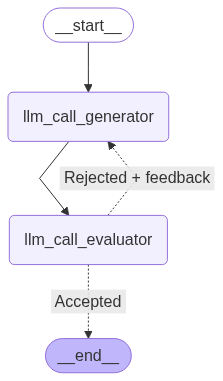

In [46]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

graph = StateGraph(State)

#add nodes
graph.add_node('llm_call_generator', llm_call_generator)
graph.add_node('llm_call_evaluator', llm_call_evaluator)

#add edges
graph.add_edge(START,'llm_call_generator')
graph.add_edge('llm_call_generator','llm_call_evaluator')
graph.add_conditional_edges(
    'llm_call_evaluator',
    route_joke,
    {
        'Accepted': END,
        'Rejected + feedback': 'llm_call_generator'
    }
)

graph = graph.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [51]:
#invoke 
state = {'topic':'undies'}
result = graph.invoke(state)


In [52]:
result

{'joke': 'Why did the pair of undies refuse to tell a joke?  \n\nBecause they didn’t want to get caught with their *pants* down—unless you think that’s a *brief* enough punchline!',
 'topic': 'undies',
 'feedback': 'The joke relies heavily on underwear puns which may be considered cheesy or not funny to some people. The unexpected twist at the end provides the punchline, however, the wordplay might be too straightforward for some.',
 'funny_or_not': 'funny'}